In [93]:
from rdkit import Chem
import numpy as np
import sys
sys.path.append('../')
sys.path.append('../data_processing/')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from sklearn.cluster import DBSCAN, HDBSCAN

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from data_processing.utils import ATOM_TYPE_MAPPING, PP_TYPE_MAPPING, ATOM_FAMILIES, MAP_ATOM_TYPE_AROMATIC_TO_INDEX

In [13]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

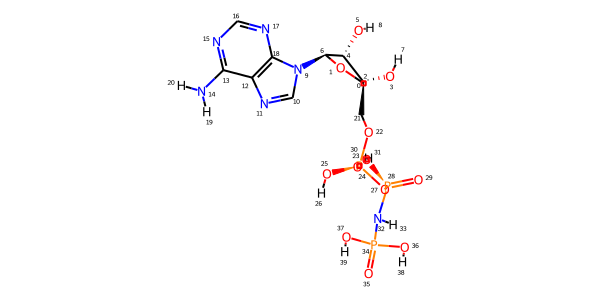

In [40]:
path = '../../data/small_dataset/raw/ZAP70_HUMAN_327_607_0/2ozo_A_rec_2ozo_anp_lig_tt_docked_2.sdf'
rdmol = Chem.MolFromMolFile(path, removeHs=False, sanitize=True)
rdmol

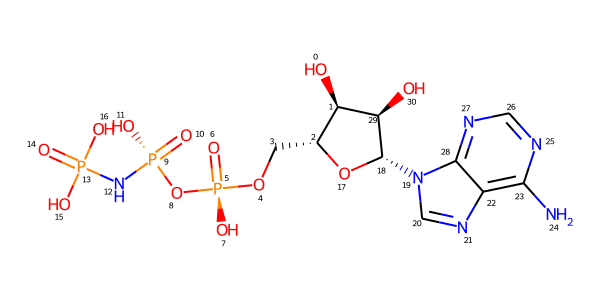

In [41]:
mol = Chem.MolFromSmiles(Chem.MolToSmiles(rdmol))
mol

In [42]:
print(len(rdmol.GetAtoms()), len(mol.GetAtoms()))

40 31


- atomic number becomes different -> don't use this mol to show pp/cluster

In [43]:
len(rdmol.GetConformers())

1

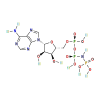

In [44]:
pbmol = next(pybel.readfile("sdf", path))
pbmol

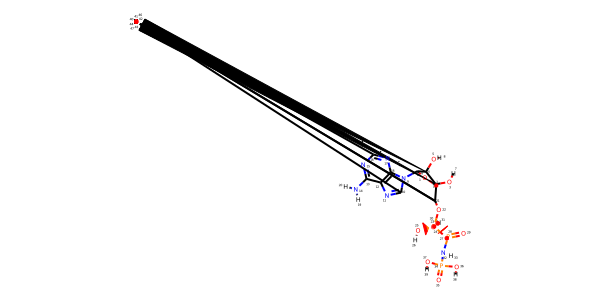

In [45]:
# not normal at all?????

rdmol = Chem.AddHs(rdmol)
rdmol

In [46]:
len(rdmol.GetAtoms())

48

In [47]:
ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None)
ligand_full = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False)
len(ligand.graph.node_clusters)

3

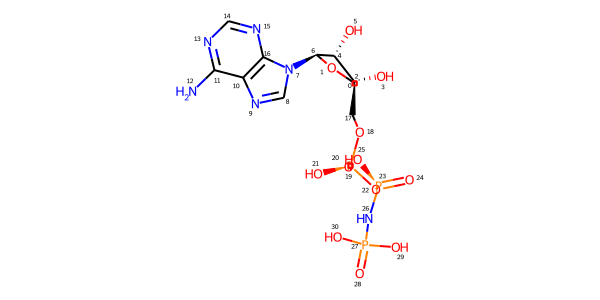

In [48]:
rdmol = ligand.rdmol_noH
rdmol

In [50]:
len(rdmol.GetAtoms())

31

In [51]:
n_atom = 0
n = 0
for cluster in ligand.graph.node_clusters:
    print(len(cluster.nodes))
    n += cluster.positions.shape[1]
    for node in cluster.nodes:
        atom_idx = node.atom_indices
        print(atom_idx)
        n_atom += len(atom_idx)
print('total number of atoms involved in at least one cluster:', n_atom)  # there are overlappings
print('total number of pp nodes in all clusters:', n)

1
{10, 11, 13, 14, 15, 16}
1
{18, 19, 20, 21, 22}
1
{28}
total number of atoms involved in at least one cluster: 12
total number of pp nodes in all clusters: 3


- Overlapping problem: some atoms exist in multiple pp/clusters

In [52]:
atom_indice_list = []

for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)
    atom_indice_list.append(atom_indices)
    
atom_indice_list

[ 22.611116 -13.793384 -10.184682]
['Aromatic'] 0
[10, 11, 13, 14, 15, 16]
[ 27.9741 -19.2302 -10.8439]
['Anion'] 1
[18, 19, 20, 21, 22]
[ 28.4022 -24.2515  -8.4428]
['HBond_acceptor'] 2
[28]


[[10, 11, 13, 14, 15, 16], [18, 19, 20, 21, 22], [28]]

In [53]:
ligand.atom_positions.squeeze().shape

(31, 3)

In [54]:
ligand.num_atoms

31

In [55]:
# direct get positions from conformer will include Hs
conformer = rdmol.GetConformer()
conformer.GetPositions().shape

(31, 3)

In [56]:
all_pp = []
for i, (pp_type, pp_node) in enumerate(ligand.pharmacophore_list):
    atom_indices = tuple([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else tuple(sorted(pp_node.atom_indices))
#     print(pp_type, atom_indices)
    all_pp.append([pp_type, atom_indices, i])
    

all_pp

[['Aromatic', (10, 11, 13, 14, 15, 16), 0],
 ['Anion', (18, 19, 20, 21, 22), 1],
 ['HBond_acceptor', (28,), 2]]

In [49]:
# already added to the ligand class

# def remove_overlapping_pp(pp_list):
#     # Sort clusters by size in descending order
#     pp_list.sort(key=lambda x:len(x[1]), reverse=True)

#     unique_nodes = set()
#     non_overlapping_pp = []

#     for pp in pp_list:
#         # If cluster nodes are not in unique_nodes, add them
#         if not any(node in unique_nodes for node in pp[1]):
#             unique_nodes.update(pp[1])
#             non_overlapping_pp.append(pp)

#     return non_overlapping_pp

In [50]:
# pp_list = remove_overlapping_pp(all_pp)
# pp_list

[['Aromatic', (0, 1, 2, 6, 8, 9), 6],
 ['Hydrophobic', (13,), 0],
 ['Hydrophobic', (14,), 1],
 ['Hydrophobic', (15,), 2],
 ['Hydrophobic', (16,), 3],
 ['Hydrophobic', (22,), 4],
 ['Hydrophobic', (24,), 5],
 ['HBond_donor', (7,), 9],
 ['HBond_donor', (17,), 10],
 ['HBond_donor', (20,), 11],
 ['HBond_acceptor', (3,), 13]]

In [57]:
one_hot_encoding = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'P': 5, 'S': 6, 'Cl': 7}    # 8 classes
one_hot_x = [one_hot_encoding[atom.GetSymbol()] for atom in rdmol.GetAtoms()]
one_hot_x

[1,
 3,
 1,
 3,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 3,
 5,
 3,
 3,
 3,
 5,
 3,
 3,
 2,
 5,
 3,
 3,
 3]

In [58]:
one_hot_x_tensor = torch.tensor(one_hot_x, dtype=torch.long)
one_hot_x_tensor = torch.nn.functional.one_hot(one_hot_x_tensor, num_classes=len(one_hot_encoding.keys())).to(torch.float)
one_hot_x_tensor

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0

In [56]:
# random.seed(2024)
# random.shuffle(all_pp)
# num = [3, 4, 5, 6, 7]
# num_p = [0.086, 0.0864, 0.389, 0.495, 0.0273]  # P(Number of Pharmacophore points)
# num_ = sample_probability(num, num_p, 1)
# num_

[5]

In [39]:
# type_list = []
# size_ = []

# ## The randomly generated clusters are obtained,
# # and the next step is to perform a preliminary merging of these randomly generated clusters with identical elements
# if len(all_pp) >= int(num_[0]):
#     mol_phco = all_pp[:int(num_[0])]
# else:
#     mol_phco = all_pp

# for pharmocophore_all_i in range(len(mol_phco)):
#     for pharmocophore_all_j in range(len(mol_phco)):
#         if mol_phco[pharmocophore_all_i][1] == mol_phco[pharmocophore_all_j][1] \
#                 and mol_phco[pharmocophore_all_i][0] != mol_phco[pharmocophore_all_j][0]:
#             index_ = [min(mol_phco[pharmocophore_all_i][0], mol_phco[pharmocophore_all_j][0]),
#                       max(mol_phco[pharmocophore_all_i][0], mol_phco[pharmocophore_all_j][0])]
#             mol_phco[pharmocophore_all_j] = [index_, mol_phco[pharmocophore_all_i][1], mol_phco[pharmocophore_all_i][2]]
#             mol_phco[pharmocophore_all_i] = [index_, mol_phco[pharmocophore_all_i][1], mol_phco[pharmocophore_all_i][2]]
#         else:
#             index_ = mol_phco[pharmocophore_all_i][0]

In [40]:
# mol_phco

[['Aromatic', (0, 2, 3, 4, 5), 7],
 ['HBond_acceptor', (3,), 13],
 ['Hydrophobic', (13,), 2],
 ['Hydrophobic', (18,), 4],
 ['Hydrophobic', (14,), 3],
 ['Hydrophobic', (12,), 1]]

In [41]:
# unique_index_filter = []
# unique_index = []
# for mol_phco_candidate_single in mol_phco:
#     if mol_phco_candidate_single not in unique_index:
#         if type(mol_phco[0]) == list:
#             unique_index.append(mol_phco_candidate_single)
#         else:
#             unique_index.append([[mol_phco_candidate_single[0]], mol_phco_candidate_single[1]], mol_phco[pharmocophore_all_i][2])
# for unique_index_single in unique_index:
#     if unique_index_single not in unique_index_filter:
#         unique_index_filter.append(unique_index_single)

In [42]:
# unique_index_filter

[['Aromatic', (0, 2, 3, 4, 5), 7],
 ['HBond_acceptor', (3,), 13],
 ['Hydrophobic', (13,), 2],
 ['Hydrophobic', (18,), 4],
 ['Hydrophobic', (14,), 3],
 ['Hydrophobic', (12,), 1]]

In [43]:
# ## The following is the order of the pharmacophores by atomic number
# sort_index_list = []
# for unique_index_filter_i in unique_index_filter:  ## Collect the mean of the participating elements
#     sort_index = sum(unique_index_filter_i[1]) / len(unique_index_filter_i[1])
#     sort_index_list.append(sort_index)
# sorted_id = sorted(range(len(sort_index_list)), key=lambda k: sort_index_list[k])
# unique_index_filter_sort = []
# for index_id in sorted_id:
#     unique_index_filter_sort.append(unique_index_filter[index_id])

In [44]:
# unique_index_filter_sort

[['Aromatic', (0, 2, 3, 4, 5), 7],
 ['HBond_acceptor', (3,), 13],
 ['Hydrophobic', (12,), 1],
 ['Hydrophobic', (13,), 2],
 ['Hydrophobic', (14,), 3],
 ['Hydrophobic', (18,), 4]]

In [46]:
# new_pp_list = []
# for item in unique_index_filter_sort:
#     idx = item[2]
#     new_pp_list.append(ligand.pharmacophore_list[idx])
# new_pp_list

[('Aromatic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee5780>),
 ('HBond_acceptor',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee8190>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635beea320>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee8280>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635beea290>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee82e0>)]

In [59]:
def group_by(mol, ligand, level='pp'):
    my_cmap = matplotlib.colormaps['coolwarm']
#     my_cmap = cm.get_cmap('coolwarm')
    if level == 'cluster':
        n_group = len(ligand.graph.node_clusters)
    elif level == 'pp':
        n = 0
        for cluster in ligand.graph.node_clusters:
            n += cluster.positions.shape[1]
        n_group = n
        pp_id = 0
        
    my_norm = Normalize(vmin=0, vmax=n_group)
    atommap, bondmap = {}, {}
    for i in range(len(ligand.graph.node_clusters)):
        cluster = ligand.graph.node_clusters[i]
        for node in cluster.nodes:
#             node = cluster.nodes[pp_id]
            atom_idx = node.atom_indices
            if level == 'cluster':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(i))
                atommap.update({atom_id:my_cmap(my_norm(i))[:3] for atom_id in atom_idx})
            elif level == 'pp':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(pp_id))
                atommap.update({atom_id:my_cmap(my_norm(pp_id))[:3] for atom_id in atom_idx})
                pp_id += 1
                
    highlights = {
        "highlightAtoms": list(atommap.keys()),
        "highlightAtomColors": atommap,
        "highlightBonds": list(bondmap.keys()),
        "highlightBondColors": bondmap,
    }
    mol_ = rdMolDraw2D.PrepareMolForDrawing(mol)
    imgsize = (600, 300)
    drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
    drawer.DrawMolecule(mol_, **highlights)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))

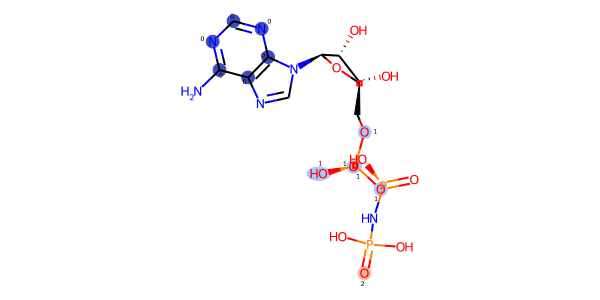

In [60]:
group_by(rdmol, ligand, 'cluster')

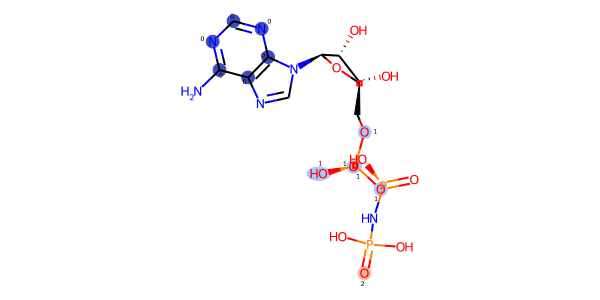

In [61]:
group_by(rdmol, ligand, 'pp')

In [63]:
# the atom ids in mol and rdmol are different, so don't run this
# group_by(mol, ligand, 'pp')

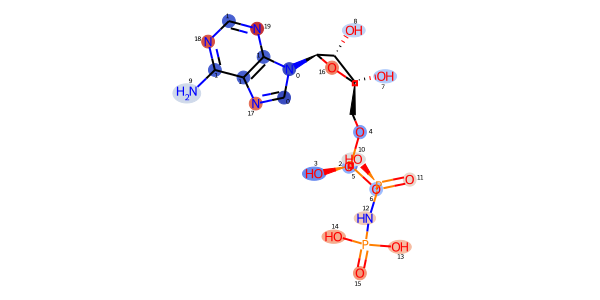

In [64]:
group_by(rdmol, ligand_full, 'pp')

# Observations
- the atoms not inside any pharmacophores: can we consider them some linkage group between any two pps?
- how about the ones outside
- distances are of different scale in different mols. hard threshould may not be rational. **always rmb this!**

## Option 1: Build the group outside pharmacophores manully
- center group (similar dist to all pharmacophores)
- linkage group between pharmacophores 
    - 0: between pp 0 and 1; 1: 1-2; ...; -1: -1:0
- peripheral group (either outside one pharmacophore, or too distant from all pharmacophores):
    - closer to one pp, distant to the others

> related with the pps, but many cases to consider

## Option 2: DBSCAN based clustering methods
> directly cluster according to the non-pp nodes positions, regardless of pp nodes

In [67]:
def extract_pp(ligand, num_class):
    pp_type_mapping = PP_TYPE_MAPPING

    atom_indice_list = []
    position_list = []
    pp_type_list = []
    pp_index_list = []
    
    for pp_node in ligand.graph.nodes:
        atom_indices = list([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else list(sorted(pp_node.atom_indices))
        positions = pp_node.positions.squeeze()
        index = pp_node.index
        # types = [one_hot_encoding[type] for type in pp_node.types]
        types = pp_type_mapping[pp_node.types[0]]  # we can't have multiple types for one pharmacophore, so we just take the first one

        atom_indice_list.append(atom_indices)
        position_list.append(positions)
        pp_index_list.append(index)
        pp_type_list.append(types)

    # atom_indices_tensor = torch.tensor(atom_indice_list, dtype=torch.long)
    positions_tensor = torch.tensor(np.array(position_list), dtype=torch.float)
    # one_hot_pp_tensor = torch.nn.functional.one_hot(torch.tensor(pp_type_list, dtype=torch.long), num_classes=len(pp_type_mapping.keys())).to(torch.float)
    one_hot_pp_tensor = torch.nn.functional.one_hot(torch.tensor(np.array(pp_type_list), dtype=torch.long), num_classes=num_class).to(torch.float)
    pp_index_tensor = torch.tensor(np.array(pp_index_list), dtype=torch.long)

    return atom_indice_list, positions_tensor, one_hot_pp_tensor, pp_index_tensor

In [182]:
num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(MAP_ATOM_TYPE_AROMATIC_TO_INDEX.keys()))
pp_atom_indices, pp_positions, pp_types, pp_index = extract_pp(ligand, num_feat_class)

In [183]:
atom_in_pp = []
for atom_indices in pp_atom_indices:
    atom_in_pp += atom_indices

atom_in_pp

[10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 28]

In [184]:
print(ligand.atom_positions, pp_positions)

[[[ 28.1677 -15.3772 -11.0614]]

 [[ 27.0984 -14.651  -11.6254]]

 [[ 28.1226 -15.2614  -9.5563]]

 [[ 29.4039 -15.0489  -9.0415]]

 [[ 27.2109 -14.0934  -9.305 ]]

 [[ 27.9357 -12.9032  -9.1948]]

 [[ 26.3866 -14.0443 -10.5711]]

 [[ 25.1045 -14.7162 -10.3833]]

 [[ 24.8594 -16.0508 -10.298 ]]

 [[ 23.5333 -16.33   -10.1489]]

 [[ 22.962  -15.1113 -10.149 ]]

 [[ 21.624  -14.7618 -10.0385]]

 [[ 20.608  -15.7476  -9.8918]]

 [[ 21.3074 -13.4335 -10.0775]]

 [[ 22.2789 -12.4745 -10.2223]]

 [[ 23.5954 -12.8295 -10.3314]]

 [[ 23.899  -14.1497 -10.2894]]

 [[ 28.0637 -16.8402 -11.4574]]

 [[ 28.4063 -17.6573 -10.3776]]

 [[ 27.9741 -19.2302 -10.8439]]

 [[ 27.8844 -19.2726 -12.3527]]

 [[ 26.4585 -19.6013 -10.185 ]]

 [[ 29.1634 -20.3278 -10.3105]]

 [[ 29.2944 -20.1731  -8.6195]]

 [[ 30.7297 -19.8772  -8.2484]]

 [[ 28.3049 -18.9291  -8.035 ]]

 [[ 28.8292 -21.6874  -7.8611]]

 [[ 28.6641 -22.9181  -9.1039]]

 [[ 28.4022 -24.2515  -8.4428]]

 [[ 30.0877 -23.0247 -10.0112]]

 [[ 27.368

In [185]:
len(ligand.atom_positions)

31

In [186]:
atom_positions = ligand.atom_positions
num_atom = len(ligand.atom_positions)
num_pp = len(pp_positions)

num_atom, num_pp

(31, 3)

In [187]:
len(atom_in_pp), atom_in_pp

(12, [10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 28])

In [188]:
atom_pos_dict = {i: pos for i, pos in enumerate(atom_positions)}
atom_pos_dict

{0: array([[ 28.1677, -15.3772, -11.0614]], dtype=float32),
 1: array([[ 27.0984, -14.651 , -11.6254]], dtype=float32),
 2: array([[ 28.1226, -15.2614,  -9.5563]], dtype=float32),
 3: array([[ 29.4039, -15.0489,  -9.0415]], dtype=float32),
 4: array([[ 27.2109, -14.0934,  -9.305 ]], dtype=float32),
 5: array([[ 27.9357, -12.9032,  -9.1948]], dtype=float32),
 6: array([[ 26.3866, -14.0443, -10.5711]], dtype=float32),
 7: array([[ 25.1045, -14.7162, -10.3833]], dtype=float32),
 8: array([[ 24.8594, -16.0508, -10.298 ]], dtype=float32),
 9: array([[ 23.5333, -16.33  , -10.1489]], dtype=float32),
 10: array([[ 22.962 , -15.1113, -10.149 ]], dtype=float32),
 11: array([[ 21.624 , -14.7618, -10.0385]], dtype=float32),
 12: array([[ 20.608 , -15.7476,  -9.8918]], dtype=float32),
 13: array([[ 21.3074, -13.4335, -10.0775]], dtype=float32),
 14: array([[ 22.2789, -12.4745, -10.2223]], dtype=float32),
 15: array([[ 23.5954, -12.8295, -10.3314]], dtype=float32),
 16: array([[ 23.899 , -14.1497, -

In [189]:
atom_positions

array([[[ 28.1677, -15.3772, -11.0614]],

       [[ 27.0984, -14.651 , -11.6254]],

       [[ 28.1226, -15.2614,  -9.5563]],

       [[ 29.4039, -15.0489,  -9.0415]],

       [[ 27.2109, -14.0934,  -9.305 ]],

       [[ 27.9357, -12.9032,  -9.1948]],

       [[ 26.3866, -14.0443, -10.5711]],

       [[ 25.1045, -14.7162, -10.3833]],

       [[ 24.8594, -16.0508, -10.298 ]],

       [[ 23.5333, -16.33  , -10.1489]],

       [[ 22.962 , -15.1113, -10.149 ]],

       [[ 21.624 , -14.7618, -10.0385]],

       [[ 20.608 , -15.7476,  -9.8918]],

       [[ 21.3074, -13.4335, -10.0775]],

       [[ 22.2789, -12.4745, -10.2223]],

       [[ 23.5954, -12.8295, -10.3314]],

       [[ 23.899 , -14.1497, -10.2894]],

       [[ 28.0637, -16.8402, -11.4574]],

       [[ 28.4063, -17.6573, -10.3776]],

       [[ 27.9741, -19.2302, -10.8439]],

       [[ 27.8844, -19.2726, -12.3527]],

       [[ 26.4585, -19.6013, -10.185 ]],

       [[ 29.1634, -20.3278, -10.3105]],

       [[ 29.2944, -20.1731,  -8.6

In [190]:
num_non_pp_atom = num_atom - len(atom_in_pp)
non_pp_atom_positions = [] # np.zeros((num_non_pp_atom, 3))

for i in range(num_atom):
    if i in atom_in_pp:
        continue
    else:
        # dist_i = np.zeros(num_pp)
        # for j in range(num_pp):
        #     dist_i[j] = np.linalg.norm(atom_positions[i] - pp_positions[j])
        non_pp_atom_positions.append(atom_positions[i])

non_pp_atom_positions = np.array(non_pp_atom_positions).squeeze()
non_pp_atom_positions.shape

(19, 3)

In [191]:
non_pp_atom_pos_dict = []
for i in range(num_atom):
    if i not in atom_in_pp:
        non_pp_atom_pos_dict.append({'id':i, 'pos':atom_positions[i]})

non_pp_atom_pos_dict

[{'id': 0, 'pos': array([[ 28.1677, -15.3772, -11.0614]], dtype=float32)},
 {'id': 1, 'pos': array([[ 27.0984, -14.651 , -11.6254]], dtype=float32)},
 {'id': 2, 'pos': array([[ 28.1226, -15.2614,  -9.5563]], dtype=float32)},
 {'id': 3, 'pos': array([[ 29.4039, -15.0489,  -9.0415]], dtype=float32)},
 {'id': 4, 'pos': array([[ 27.2109, -14.0934,  -9.305 ]], dtype=float32)},
 {'id': 5, 'pos': array([[ 27.9357, -12.9032,  -9.1948]], dtype=float32)},
 {'id': 6, 'pos': array([[ 26.3866, -14.0443, -10.5711]], dtype=float32)},
 {'id': 7, 'pos': array([[ 25.1045, -14.7162, -10.3833]], dtype=float32)},
 {'id': 8, 'pos': array([[ 24.8594, -16.0508, -10.298 ]], dtype=float32)},
 {'id': 9, 'pos': array([[ 23.5333, -16.33  , -10.1489]], dtype=float32)},
 {'id': 12, 'pos': array([[ 20.608 , -15.7476,  -9.8918]], dtype=float32)},
 {'id': 17, 'pos': array([[ 28.0637, -16.8402, -11.4574]], dtype=float32)},
 {'id': 23, 'pos': array([[ 29.2944, -20.1731,  -8.6195]], dtype=float32)},
 {'id': 24, 'pos': arr

In [192]:
non_pp_atom_positions = torch.tensor(non_pp_atom_positions)
non_pp_atom_positions

tensor([[ 28.1677, -15.3772, -11.0614],
        [ 27.0984, -14.6510, -11.6254],
        [ 28.1226, -15.2614,  -9.5563],
        [ 29.4039, -15.0489,  -9.0415],
        [ 27.2109, -14.0934,  -9.3050],
        [ 27.9357, -12.9032,  -9.1948],
        [ 26.3866, -14.0443, -10.5711],
        [ 25.1045, -14.7162, -10.3833],
        [ 24.8594, -16.0508, -10.2980],
        [ 23.5333, -16.3300, -10.1489],
        [ 20.6080, -15.7476,  -9.8918],
        [ 28.0637, -16.8402, -11.4574],
        [ 29.2944, -20.1731,  -8.6195],
        [ 30.7297, -19.8772,  -8.2484],
        [ 28.3049, -18.9291,  -8.0350],
        [ 28.8292, -21.6874,  -7.8611],
        [ 28.6641, -22.9181,  -9.1039],
        [ 30.0877, -23.0247, -10.0112],
        [ 27.3684, -22.5473, -10.1264]])

In [193]:
clustering_model = DBSCAN(eps=2, min_samples=2)
# clustering_model = HDBSCAN(min_cluster_size=2)
clustering = clustering_model.fit(non_pp_atom_positions)
non_pp_atom_labels = clustering.labels_
non_pp_atom_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  1,  1,  1,  1,
        1,  1])

In [194]:
max_label = np.max(non_pp_atom_labels)
max_label

1

In [195]:
# make sure the -1 label becomes a group by itself
for i in range(len(non_pp_atom_labels)):
    if non_pp_atom_labels[i] == -1:
        non_pp_atom_labels[i] = max_label + 1
        max_label += 1

print(non_pp_atom_labels, max_label)

[0 0 0 0 0 0 0 0 0 0 2 0 1 1 1 1 1 1 1] 2


In [196]:
non_pp_groups = np.unique(non_pp_atom_labels)
non_pp_groups

array([0, 1, 2])

In [197]:
non_pp_group_center_positions = torch.zeros((len(non_pp_groups), 3))
non_pp_atom_indices = {label: [] for label in non_pp_groups}

for group in non_pp_groups:
    nodes = np.where(non_pp_atom_labels==group)[0]
    print(nodes)
    atoms = []
    for node in nodes:
        # print(node)
        atoms.append(non_pp_atom_pos_dict[int(node)]['id'])
    print(atoms)
    non_pp_atom_indices[group] = atoms
    
    positions = non_pp_atom_positions[nodes]
    print(positions.size())
    center_pos = torch.mean(positions, dim=0)
    print(center_pos)
    non_pp_group_center_positions[group] = center_pos

[ 0  1  2  3  4  5  6  7  8  9 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17]
torch.Size([11, 3])
tensor([ 26.8988, -15.0288, -10.2403])
[12 13 14 15 16 17 18]
[23, 24, 25, 26, 27, 29, 30]
torch.Size([7, 3])
tensor([ 29.0398, -21.3081,  -8.8579])
[10]
[12]
torch.Size([1, 3])
tensor([ 20.6080, -15.7476,  -9.8918])


In [198]:
non_pp_group_center_positions

tensor([[ 26.8988, -15.0288, -10.2403],
        [ 29.0398, -21.3081,  -8.8579],
        [ 20.6080, -15.7476,  -9.8918]])

In [199]:
non_pp_atom_indices

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17],
 1: [23, 24, 25, 26, 27, 29, 30],
 2: [12]}

In [200]:
# non_pp_atom_indices = {label: [] for label in non_pp_groups}
# for index, label in enumerate(non_pp_atom_labels):
#     non_pp_atom_indices[label].append(index)

# non_pp_atom_indices

In [201]:
atom_in_pp

[10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 28]

In [204]:
pp_atom_indices

[[10, 11, 13, 14, 15, 16], [18, 19, 20, 21, 22], [28]]

In [202]:
# target_x = torch.zeros(x.size(0), x.size(1))
target_pos = torch.zeros(num_atom, 3)
# node_pp_index = torch.zeros(x.size(0), dtype=torch.long)
# atom_in_pp = []
noise_std=0.01

for i in range(num_atom):
    if i not in atom_in_pp:  # if the atom is not in any pharmacophore, we set its target type to Linker:0 and target position to CoM plus a bit noise
        # target_x[i] = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=pp_types.size(1)).to(torch.float)
        # target_pos[i] = torch.zeros(pos.size(1))
        # target_pos[i] = center_tensor + torch.randn_like(center_tensor) # * noise_std
        # node_pp_index[i] = -1
        for j, atom_indices in non_pp_atom_indices.items():
            if i in atom_indices:
                target_pos[i] = non_pp_group_center_positions[j] + torch.randn_like(non_pp_group_center_positions[j]) * noise_std
                break
    else:  # if the atom is in a pharmacophore, we set its target type to the pharmacophore type and target position to the pharmacophore position
        for j, atom_indices in enumerate(pp_atom_indices):
            if i in atom_indices:
                # target_x[i] = pp_types[j]
                target_pos[i] = pp_positions[j] + torch.randn_like(pp_positions[j]) * noise_std
                # node_pp_index[i] = j    # = pp_index[j]
                break

In [203]:
target_pos

tensor([[ 26.8937, -15.0397, -10.2318],
        [ 26.8931, -15.0451, -10.2432],
        [ 26.9030, -15.0202, -10.2323],
        [ 26.9003, -15.0165, -10.2129],
        [ 26.8980, -15.0311, -10.2606],
        [ 26.9143, -15.0380, -10.2088],
        [ 26.9030, -15.0239, -10.2340],
        [ 26.8950, -15.0198, -10.2286],
        [ 26.9028, -15.0377, -10.2432],
        [ 26.9097, -15.0263, -10.2575],
        [ 22.6152, -13.7839, -10.1916],
        [ 22.6247, -13.7792, -10.1882],
        [ 20.6120, -15.7379,  -9.8918],
        [ 22.6223, -13.8032, -10.1963],
        [ 22.6025, -13.7954, -10.1874],
        [ 22.5980, -13.7894, -10.1885],
        [ 22.6266, -13.7962, -10.1889],
        [ 26.8930, -15.0084, -10.2345],
        [ 27.9679, -19.2379, -10.8434],
        [ 27.9939, -19.2276, -10.8440],
        [ 27.9721, -19.2369, -10.8559],
        [ 27.9812, -19.2179, -10.8295],
        [ 27.9946, -19.2237, -10.8543],
        [ 29.0433, -21.3069,  -8.8534],
        [ 29.0441, -21.3090,  -8.8426],
